In [ ]:
"""
File Name: ex3_seq2seq_ae_anamaly_detector_v2_cbc.ipynb

Description: anomaly detection using seq2seq autoencoder with setting split = 2

Author: junghwan lee
Email: jhrrlee@gmail.com
Date Created: 2023.09.12

**Objective:**  
To develop an anomaly detection mechanism using an autoencoder trained with K-fold cross-validation. The process aims to compute error metrics on a per-cell basis, average them across K-folds, and identify anomalies based on these metrics.

**Method:**  
The outlined process consists of the following steps:

1. **Training Phase:**
    - The dataset is divided into K folds.
    - An Autoencoder is trained K times, once for each fold, resulting in K trained Autoencoder models.
    - In each iteration, one fold is used for validation while the rest are used for training.

2. **Error Calculation Phase:**
    - Compute error metrics (MAPE, RMSE, MAE, MSE) for each cell in the validation set of each fold.
    - These error metrics are computed between the original and the reconstructed data obtained from the Autoencoder.
    - These computations result in K sets of error metrics, one for each fold.

3. **Averaging Phase:**
    - Average the error metrics computed in the previous phase across all K folds.
    - This results in a single set of average error metrics for each cell.

4. **Anomaly Detection Phase:**
    - Detect anomalies based on the specified error metric and a provided or computed threshold.
    - Flag the cells whose error metrics exceed the threshold as anomalies.

5. **Visualization Phase:**
    - Visualize the average error metrics by cell using bar charts, one for each error metric (MAPE, RMSE, MAE, MSE).
    - Highlight the anomalies in red on these charts to clearly indicate the anomalous cells.

**Functions:**

- `train_autoencoder(data, no_of_folds)`:  
  Train the Autoencoder using K-fold cross-validation.

- `compute_reconstruction_error(model)`:  
  Compute the reconstruction error metrics (MAPE, RMSE, MAE, MSE) for each cell.

- `detect_anomalies(average_error_metrics_by_cells, metric, threshold_function, threshold_value)`:  
  Detect anomalies based on a specified error metric and threshold.

- `plot_average_error_metrics_by_cells(average_error_metrics_by_cells, anomalies)`:  
  Visualize the average error metrics by cell, highlighting the anomalies.


In [1]:
import sys
#from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import importlib

2025-03-06 00:01:51.179105: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 00:01:51.224034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 00:01:58.083188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

In [ ]:
"""
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/dnn_models/')
data_path = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/resource/dataset/'
base_dir = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/preprocessing/cae/'
"""


In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-02-24 00:07:43.857602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-24 00:07:43.857689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-24 00:07:43.912870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-24 00:07:43.912923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-24 00:07:43.912948: I external/local_xla/xla/stream_executor

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-03-06 00:02:13.541269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:13.541368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:13.609688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:13.609746: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:13.609769: I external/local_xla/xla/stream_executor

In [3]:
sys.path.append('../')
sys.path.append('../../../auto_encoder/')
gen_path = '../../../resource/dataset/'
proj_dir = "/mnt/d/sandbox/optimal_rul"  # Change this to your actual project path
sys.path.append(proj_dir)
base_dir = './seq2seq_ae/'

In [4]:
from seq2seq_ae import create_seq2seq_ae_v1,  create_seq2seq_ae_v2,  create_seq2seq_ae_v3

In [5]:
import AnomalyDetector as AD

In [6]:
from AnomalyDetector import BatData, AutoencoderTrainer, AnomalyDetector

In [7]:
importlib.reload(AD)

<module 'AnomalyDetector' from '/mnt/d/sandbox/optimal_rul/data_analysis/p3_anomaly_detection/ex11/../AnomalyDetector.py'>

In [8]:
eol = np.load(gen_path + 'eol_21_120.npy')
cycle_data = np.load(gen_path + 'interpolated_cycle_data_21_120.npy')

In [9]:
cycle_count = np.arange(1, cycle_data.shape[1]+1)

num_cells = eol.shape[0]
num_cycles = cycle_count.shape[0]

# Repeat the EOL values for each cycle in the cycle_count array
eol_repeated = np.tile(eol, (1, num_cycles))

# Repeat the cycle_count values for each cell in the cycle_count array
cycle_count_repeated = np.tile(cycle_count, (num_cells, 1))

RUL_repeated = eol_repeated - cycle_count_repeated

print("RUL_repeated shape:", RUL_repeated.shape)
print("eol shape:", eol_repeated.shape)
print("cycle_count shape:", cycle_count_repeated.shape)
print("cycle_data shape:", cycle_data.shape)

RUL_repeated shape: (124, 100)
eol shape: (124, 100)
cycle_count shape: (124, 100)
cycle_data shape: (124, 100, 8, 1000)


In [10]:
import tensorflow as tf
def mape(y_true, y_pred):
    epsilon = 1e-9  # Adding a small constant to avoid division by zero
    error = (y_true - y_pred) / (tf.abs(y_true) + epsilon)
    return 100.0 * tf.reduce_mean(tf.abs(error))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


In [11]:
batdata = BatData(np.transpose(cycle_data, (0, 1, 3, 2)))

In [12]:
batdata.get_shape()

(124, 100, 1000, 8)

In [13]:
seq2seq_ae_v1_model, cae_v1_encoder = create_seq2seq_ae_v1(1000, 8)


(None, 1000, 8)


2025-03-06 00:02:21.676735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:21.676881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:21.676946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:21.676979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 00:02:21.677002: I external/local_xla/xla/stream_executor

(None, 1000, 8)


In [14]:
seq2seq_ae_v1_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1000, 8)        │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088 (4.25 KB)

 Trainable params: 1,088 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

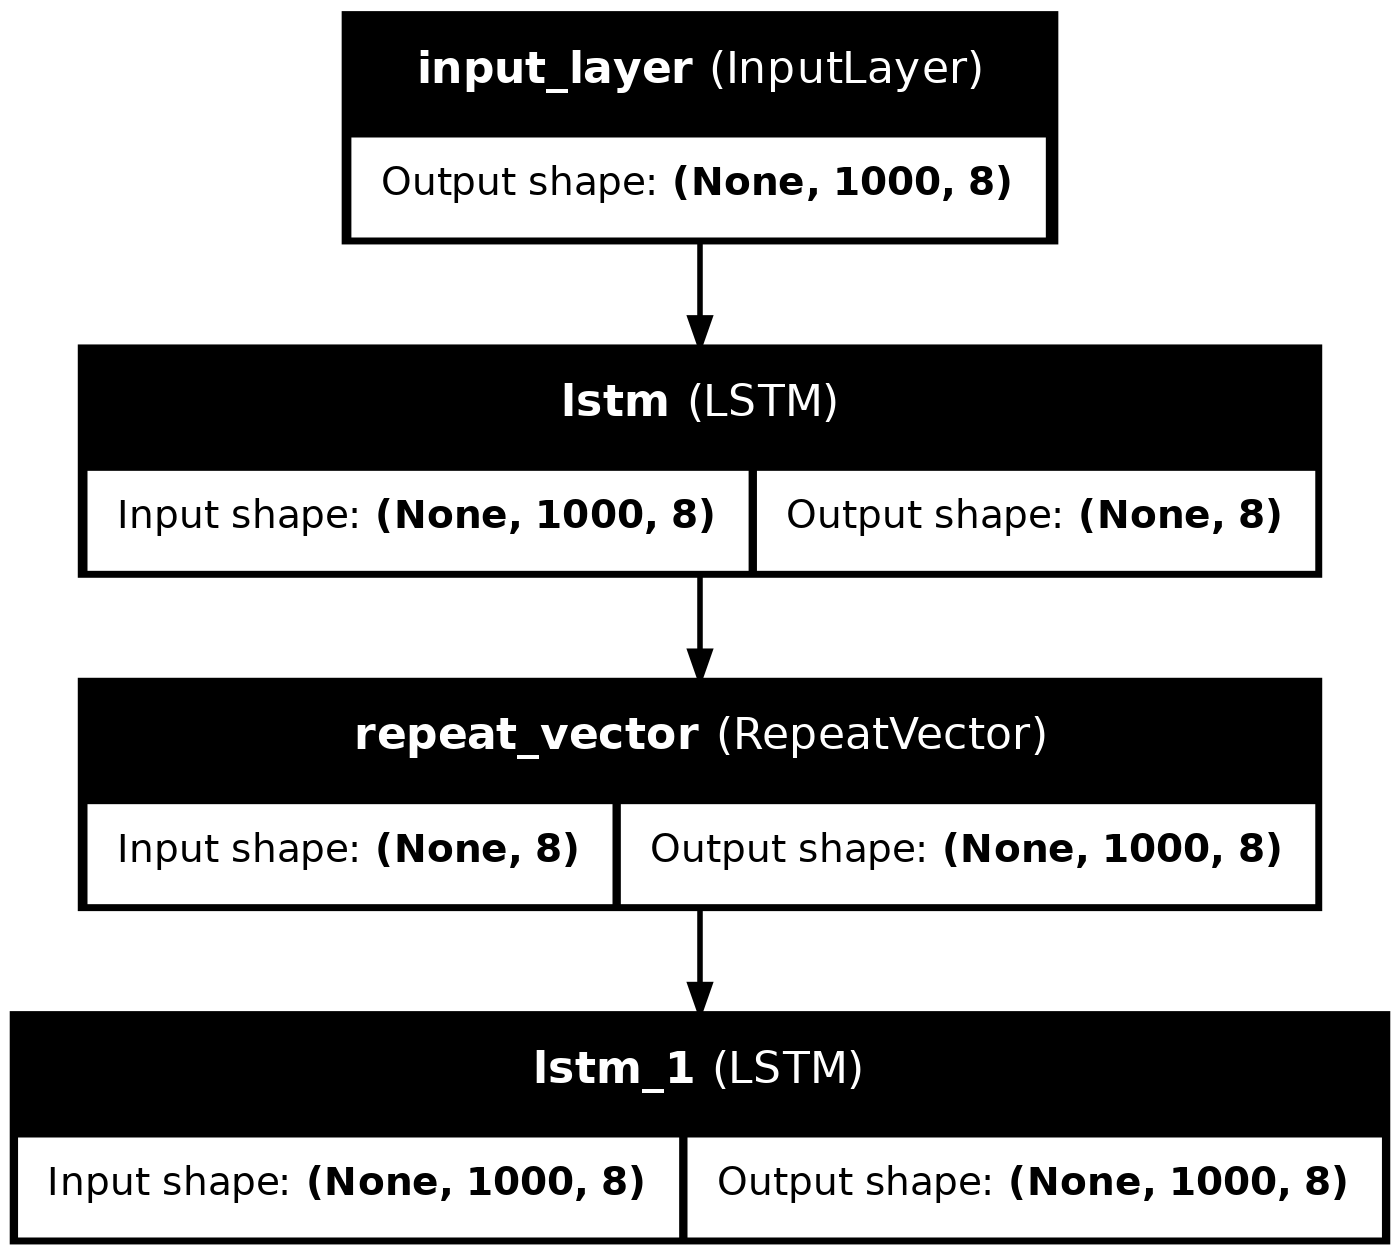

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(seq2seq_ae_v1_model, to_file='seq2seq_ae_v1_model.png', show_shapes=True, show_layer_names=True)


In [14]:
seq2seq_ae_v1 = AutoencoderTrainer(base_dir, 'create_seq2seq_ae_v1_t2', batdata, seq2seq_ae_v1_model)

In [15]:

seq2seq_ae_v1.train(learning_rate = 0.001, batch_size=128, max_epoch=300, no_patience=20)

 39%|███▊      | 116/300 [26:22<41:50, 13.64s/epoch, loss=0.524, mae=0.494, mape=552, rmse=0.724]   


In [38]:
seq2seq_ae_v1_average_error_metrics_by_cells = seq2seq_ae_v1.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step
Prediction time: 18.836268186569214 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step
[  1   3   5  14  26  41  42  44  47  48  51  53  60  61  77  82  83  86
  88 107 108 110 111 115 117]


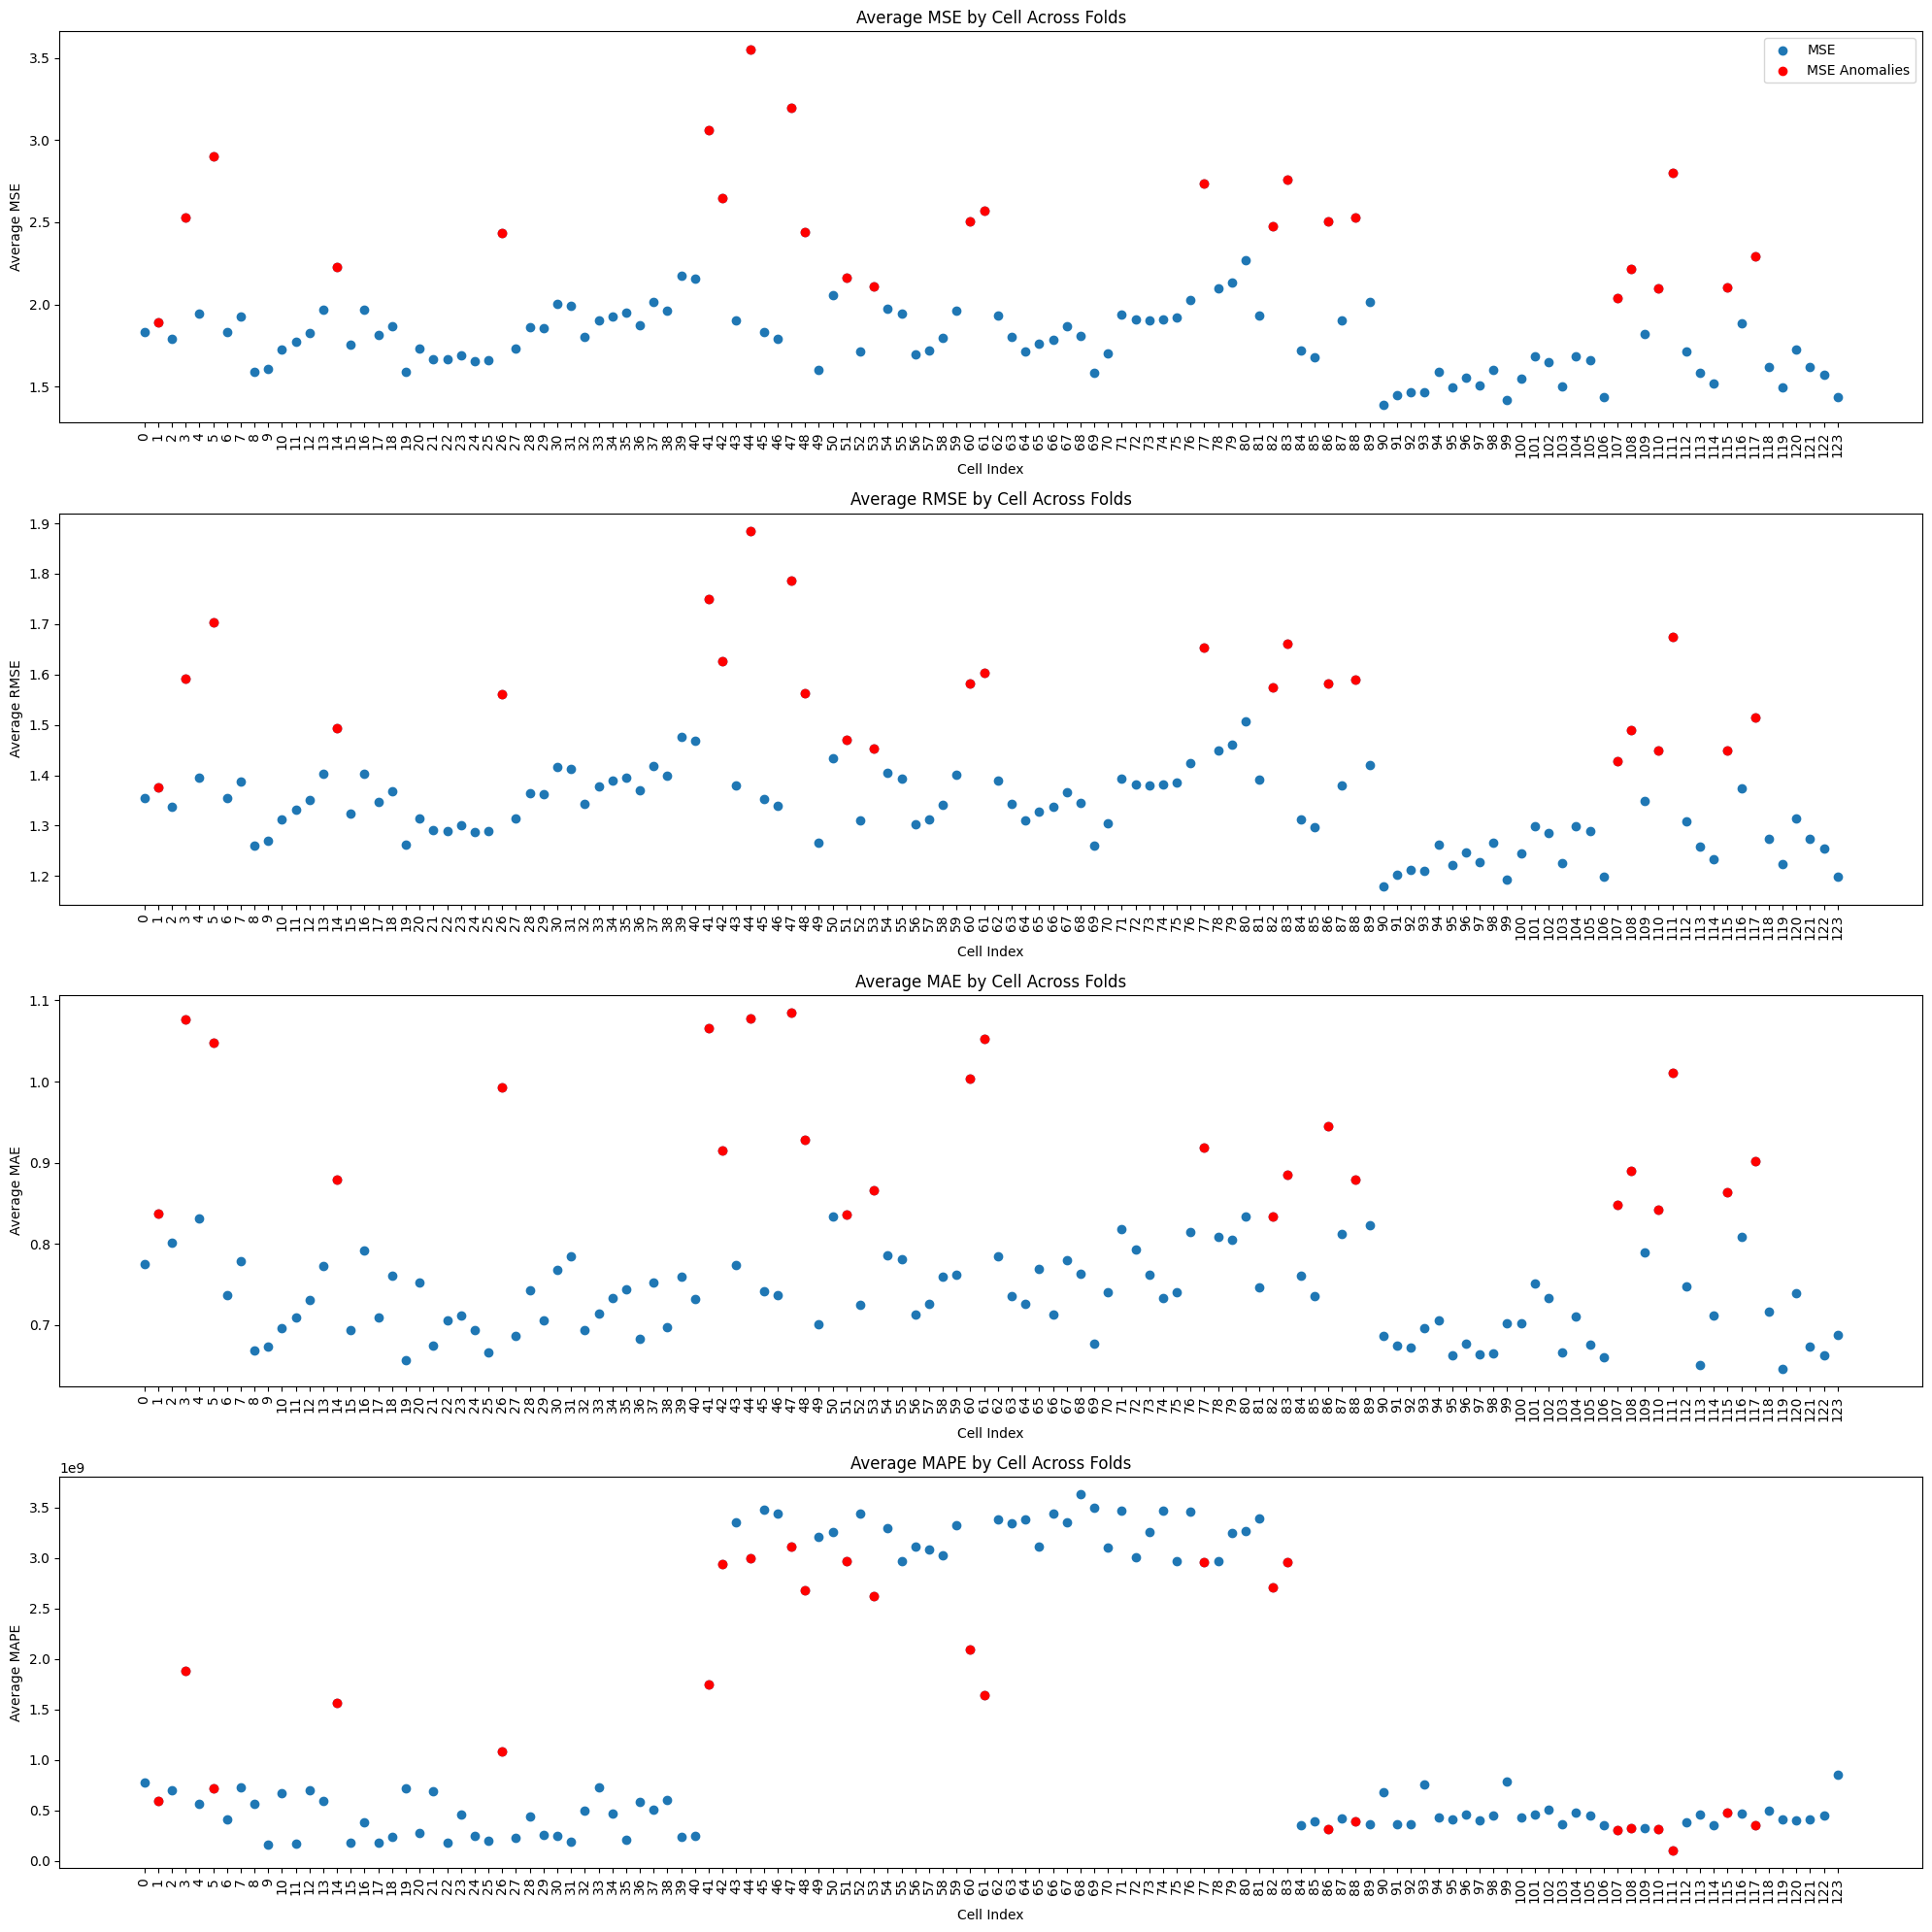

In [16]:
anomaly_detector_seq2seq_ae_v1= AnomalyDetector()
anomalies_seq2seq_ae_v1, metric_errors_seq2seq_ae_v1 = anomaly_detector_seq2seq_ae_v1.detect_anomalies(seq2seq_ae_v1_average_error_metrics_by_cells, 
                                                                                             metric='mae', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_seq2seq_ae_v1)
anomaly_detector_seq2seq_ae_v1.visual(seq2seq_ae_v1_average_error_metrics_by_cells, anomalies_seq2seq_ae_v1)

[43 45 46 47 49 50 52 54 56 59 62 63 64 65 66 67 68 69 71 73 74 76 79 80
 81]


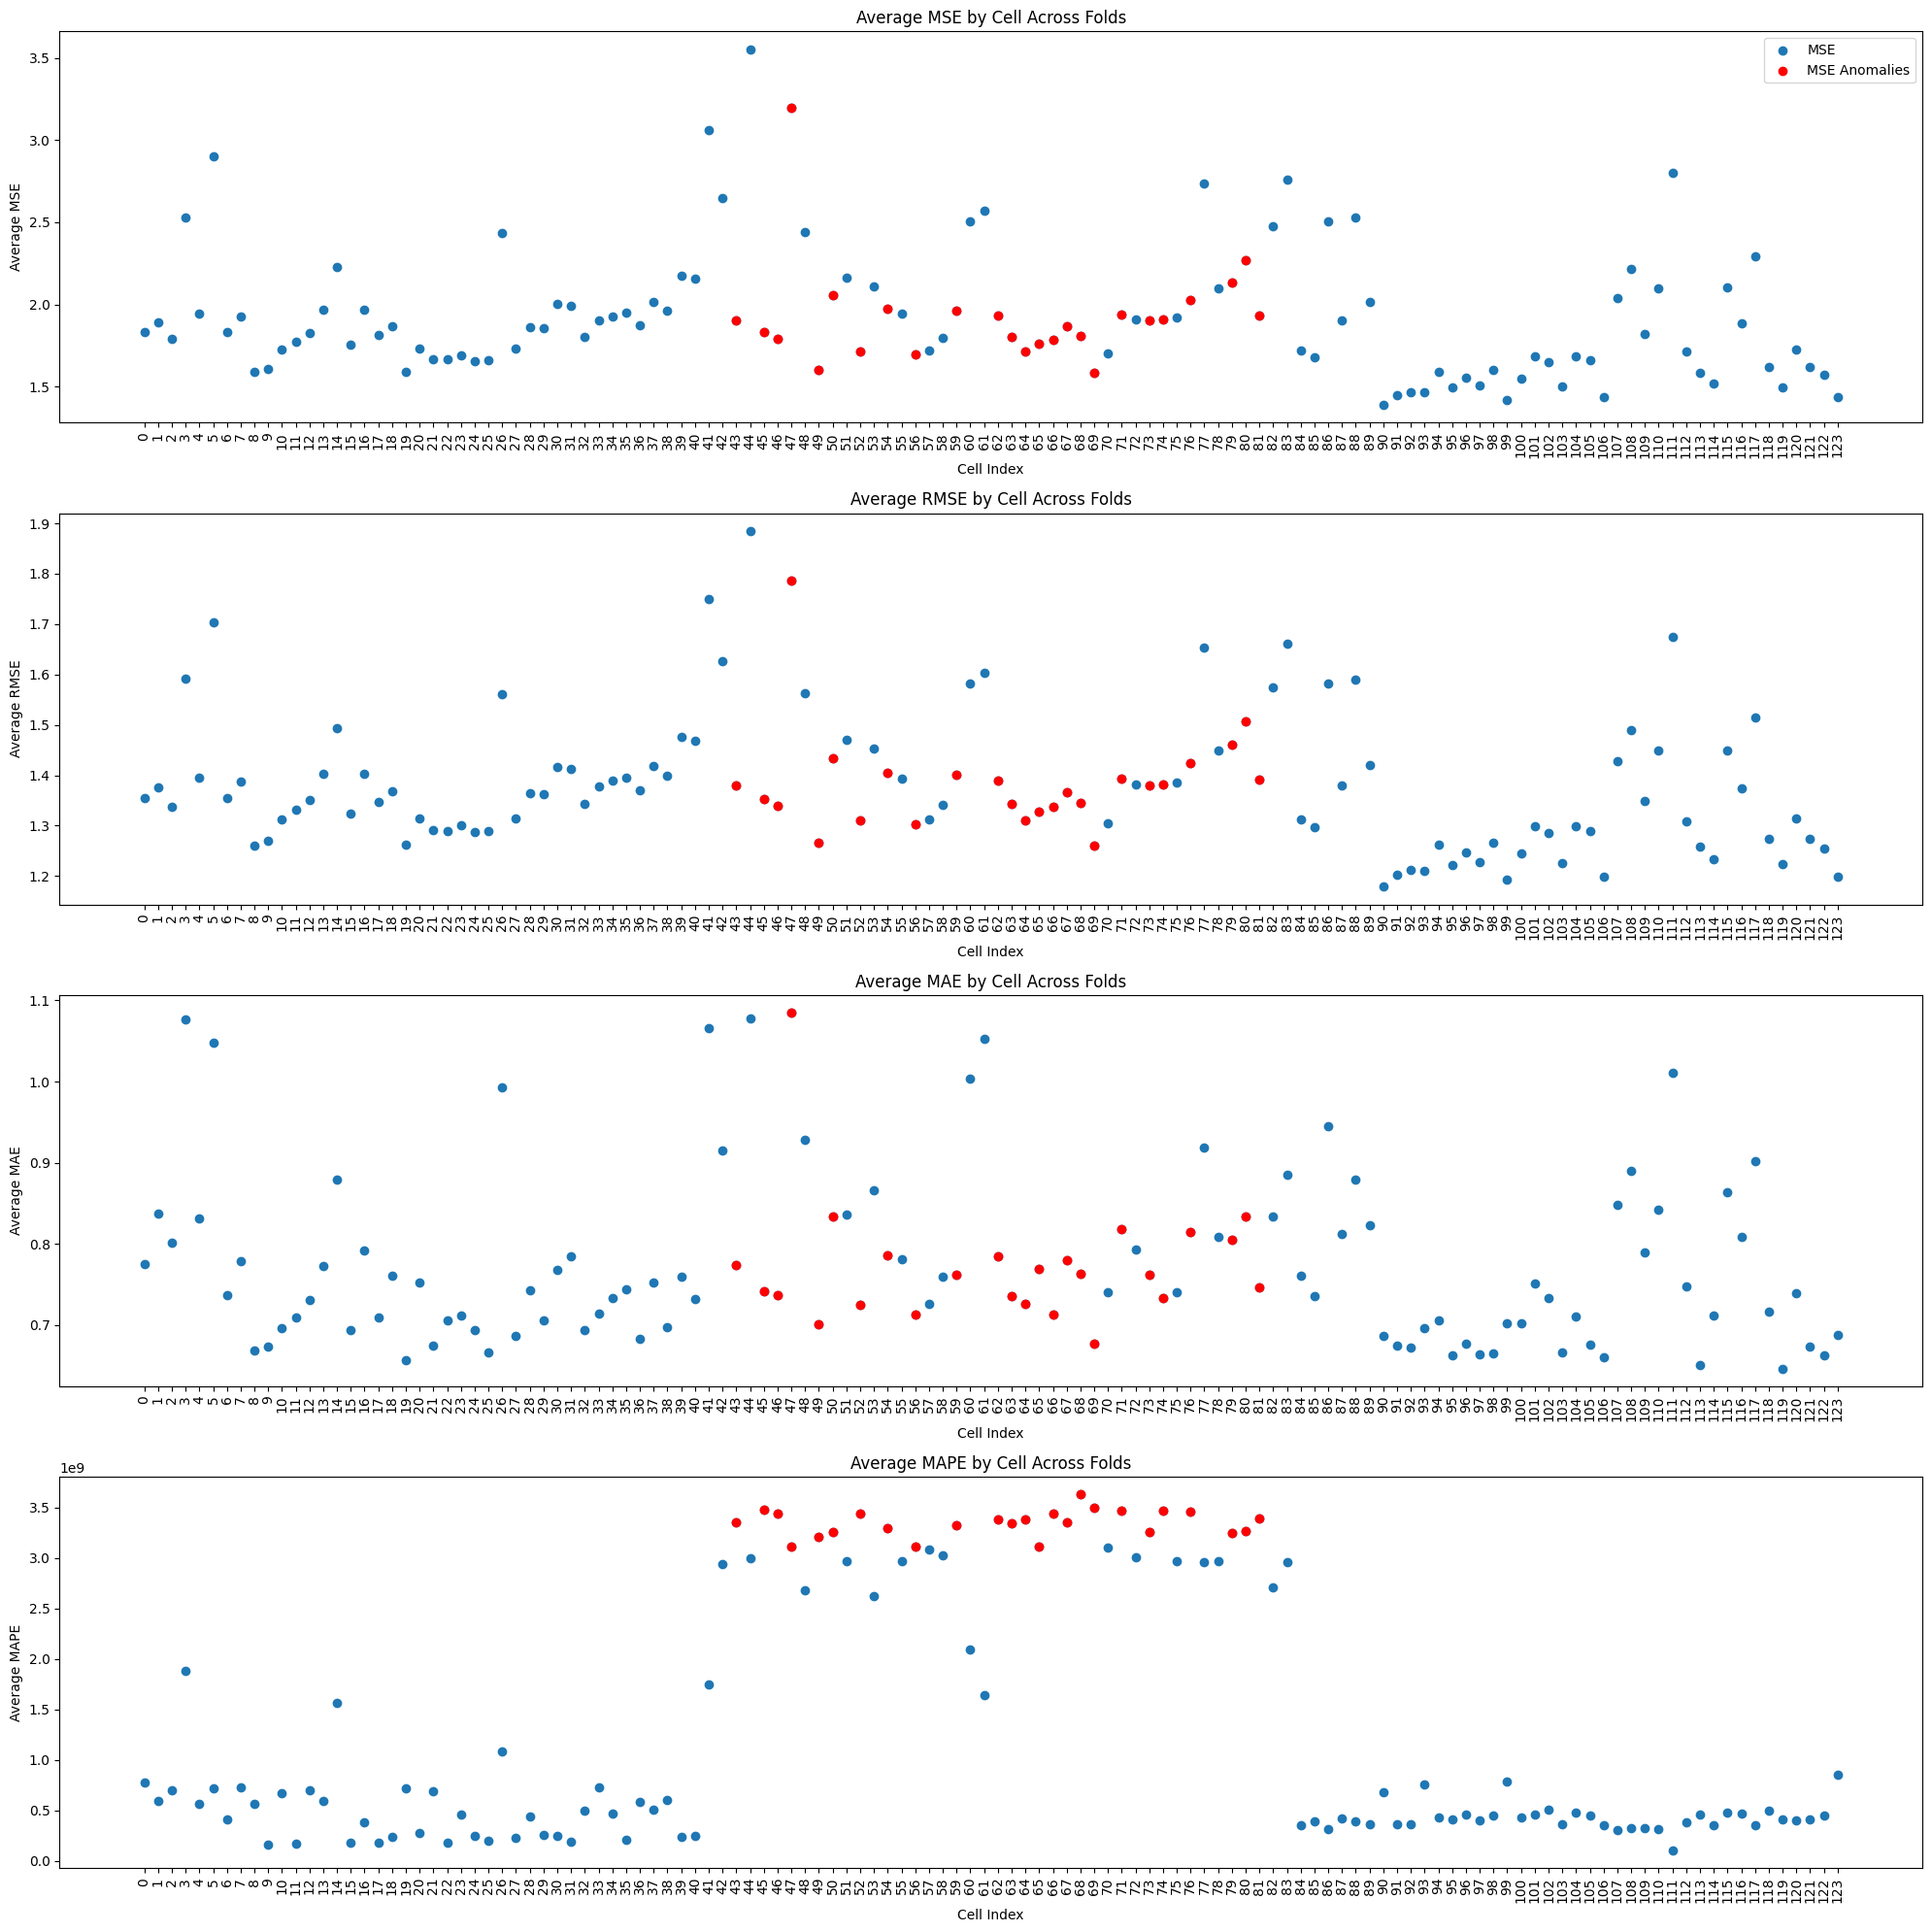

In [17]:
anomalies_seq2seq_ae_v1, metric_errors_seq2seq_ae_v1 = anomaly_detector_seq2seq_ae_v1.detect_anomalies(seq2seq_ae_v1_average_error_metrics_by_cells, 
                                                                                             metric='mape', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_seq2seq_ae_v1)
anomaly_detector_seq2seq_ae_v1.visual(seq2seq_ae_v1_average_error_metrics_by_cells, anomalies_seq2seq_ae_v1)

In [16]:
seq2seq_ae_v2_model, cae_v2_encoder = create_seq2seq_ae_v2(1000, 8)

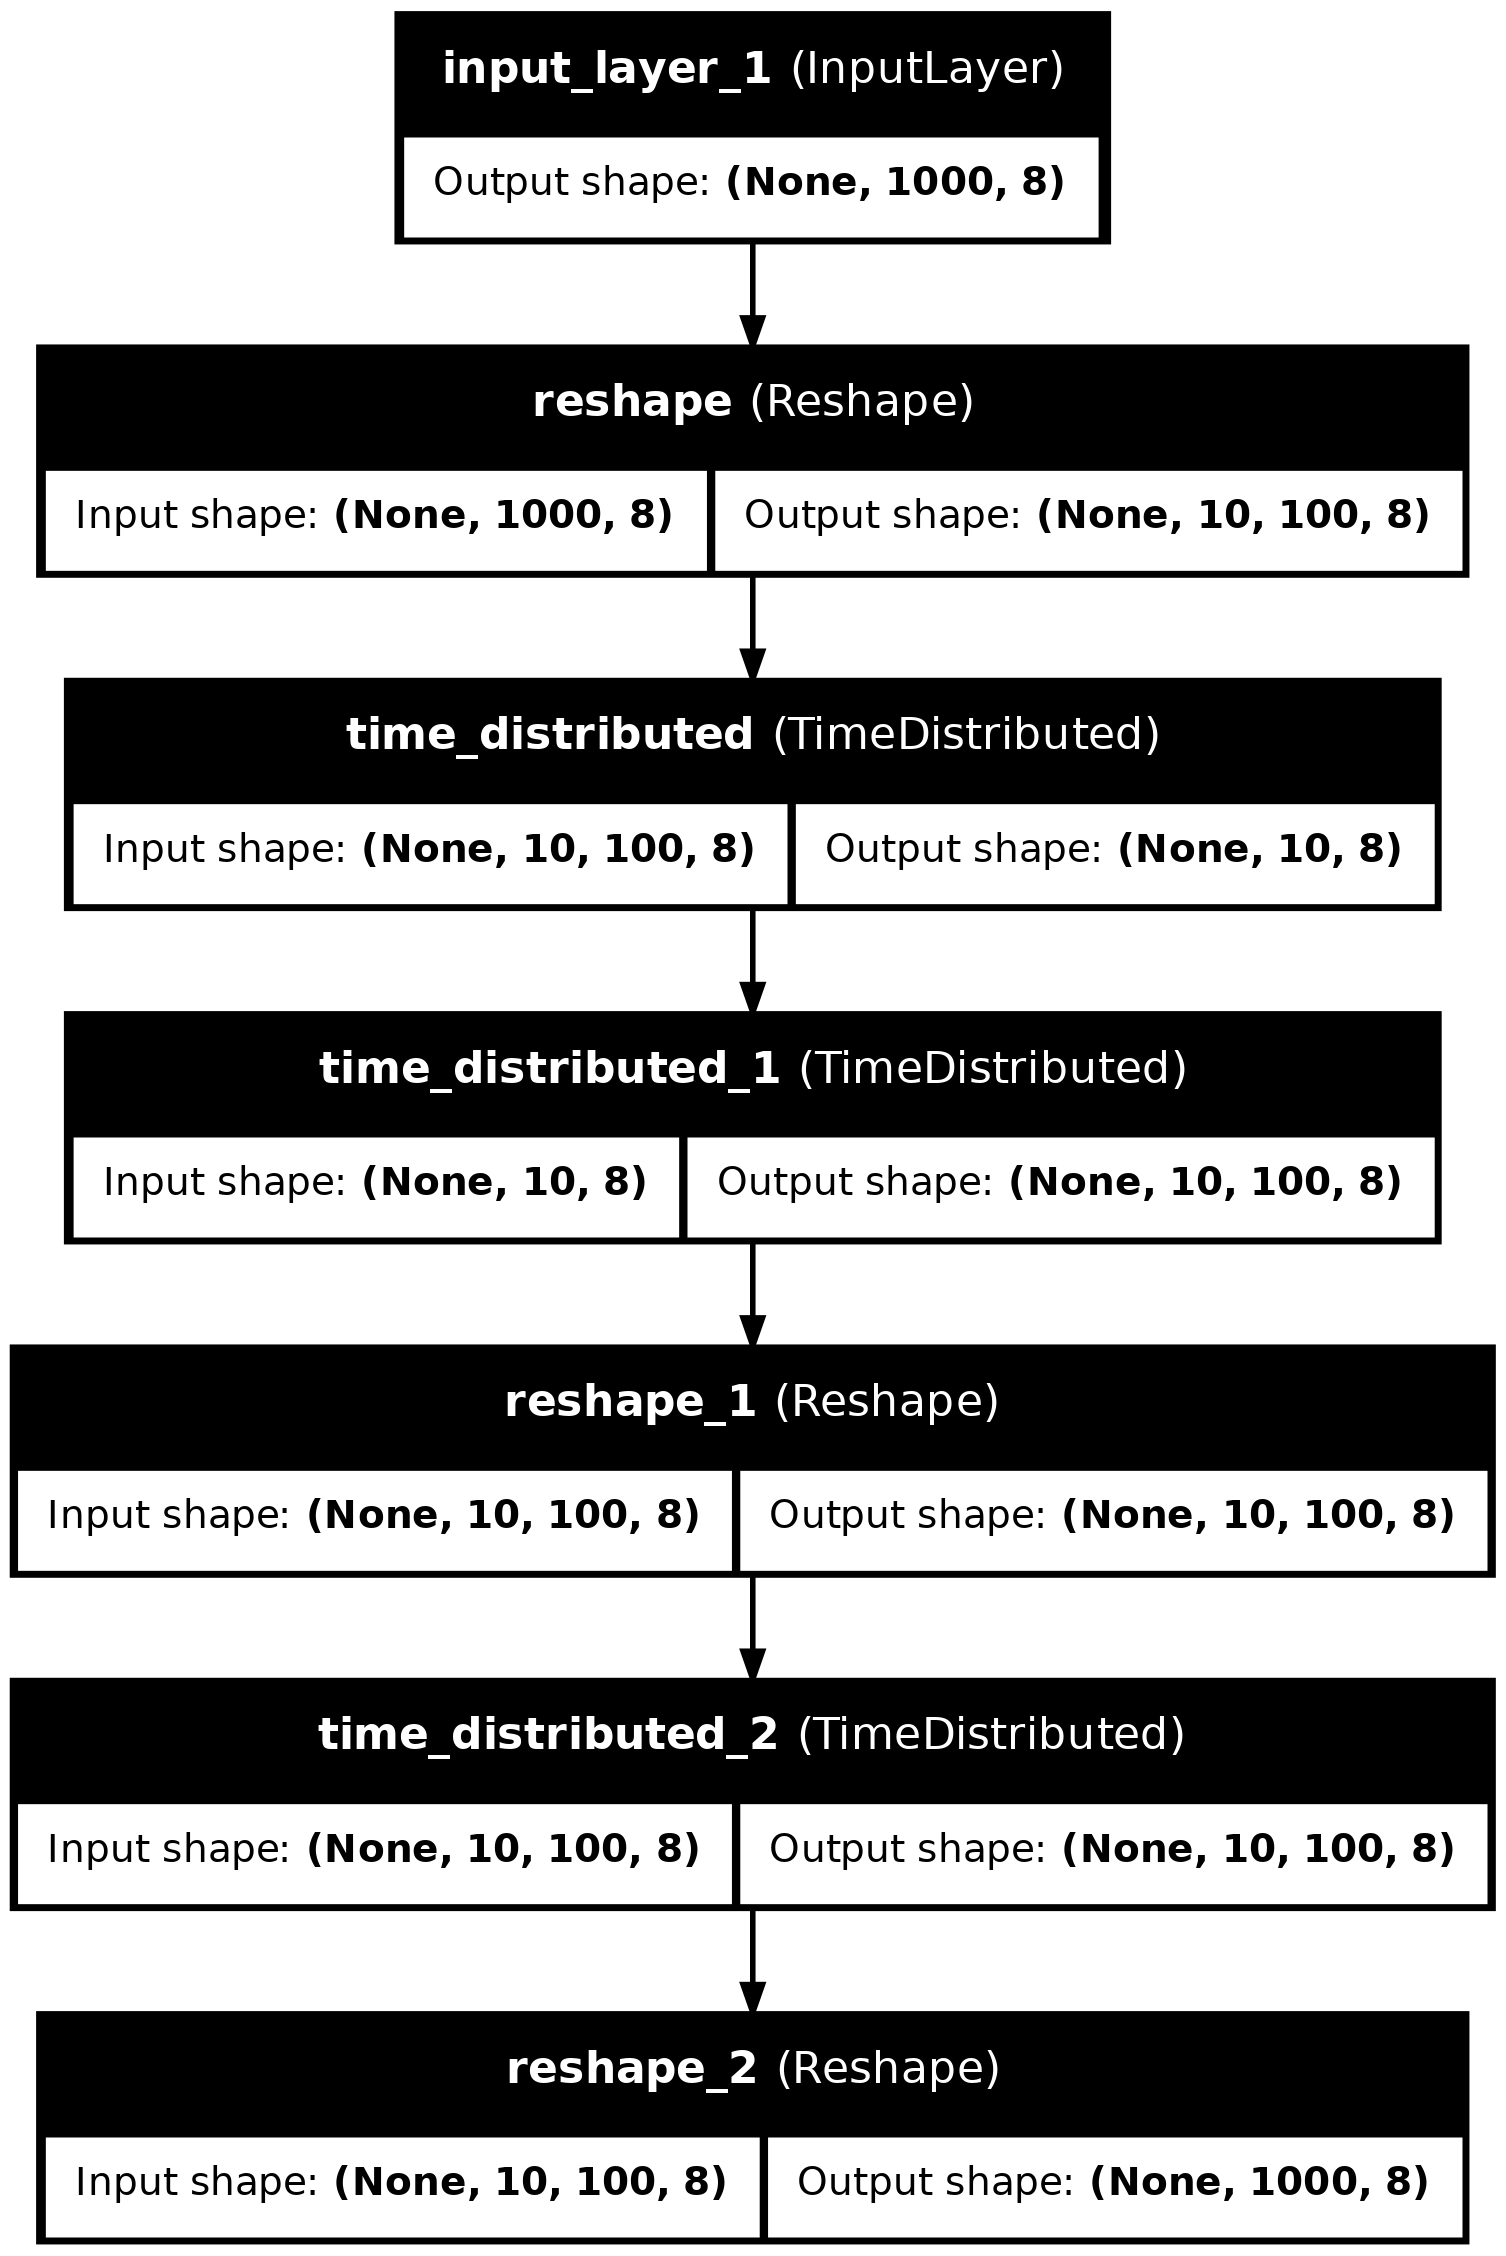

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(seq2seq_ae_v2_model, to_file='seq2seq_ae_v2_model.png', show_shapes=True, show_layer_names=True)


In [17]:
seq2seq_ae_v2_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 8)          │           544 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 100, 8)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 10, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 100, 8)     │           544 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1000, 8)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088 (4.25 KB)

 Trainable params: 1,088 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
seq2seq_ae_v2 = AutoencoderTrainer(base_dir, 'create_seq2seq_ae_v2_t2', batdata, seq2seq_ae_v2_model)

In [19]:

seq2seq_ae_v2.train(learning_rate = 0.001, batch_size=128, max_epoch=300, no_patience=20)


100%|██████████| 300/300 [1:10:02<00:00, 14.01s/epoch, loss=0.176, mae=0.225, mape=193, rmse=0.42]


In [36]:
seq2seq_ae_v2_average_error_metrics_by_cells = seq2seq_ae_v2.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step
Prediction time: 22.94556188583374 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step
[  3  14  26  41  42  44  47  48  50  60  61  71  77  82  83  86  88 101
 107 108 109 110 115 116 117]


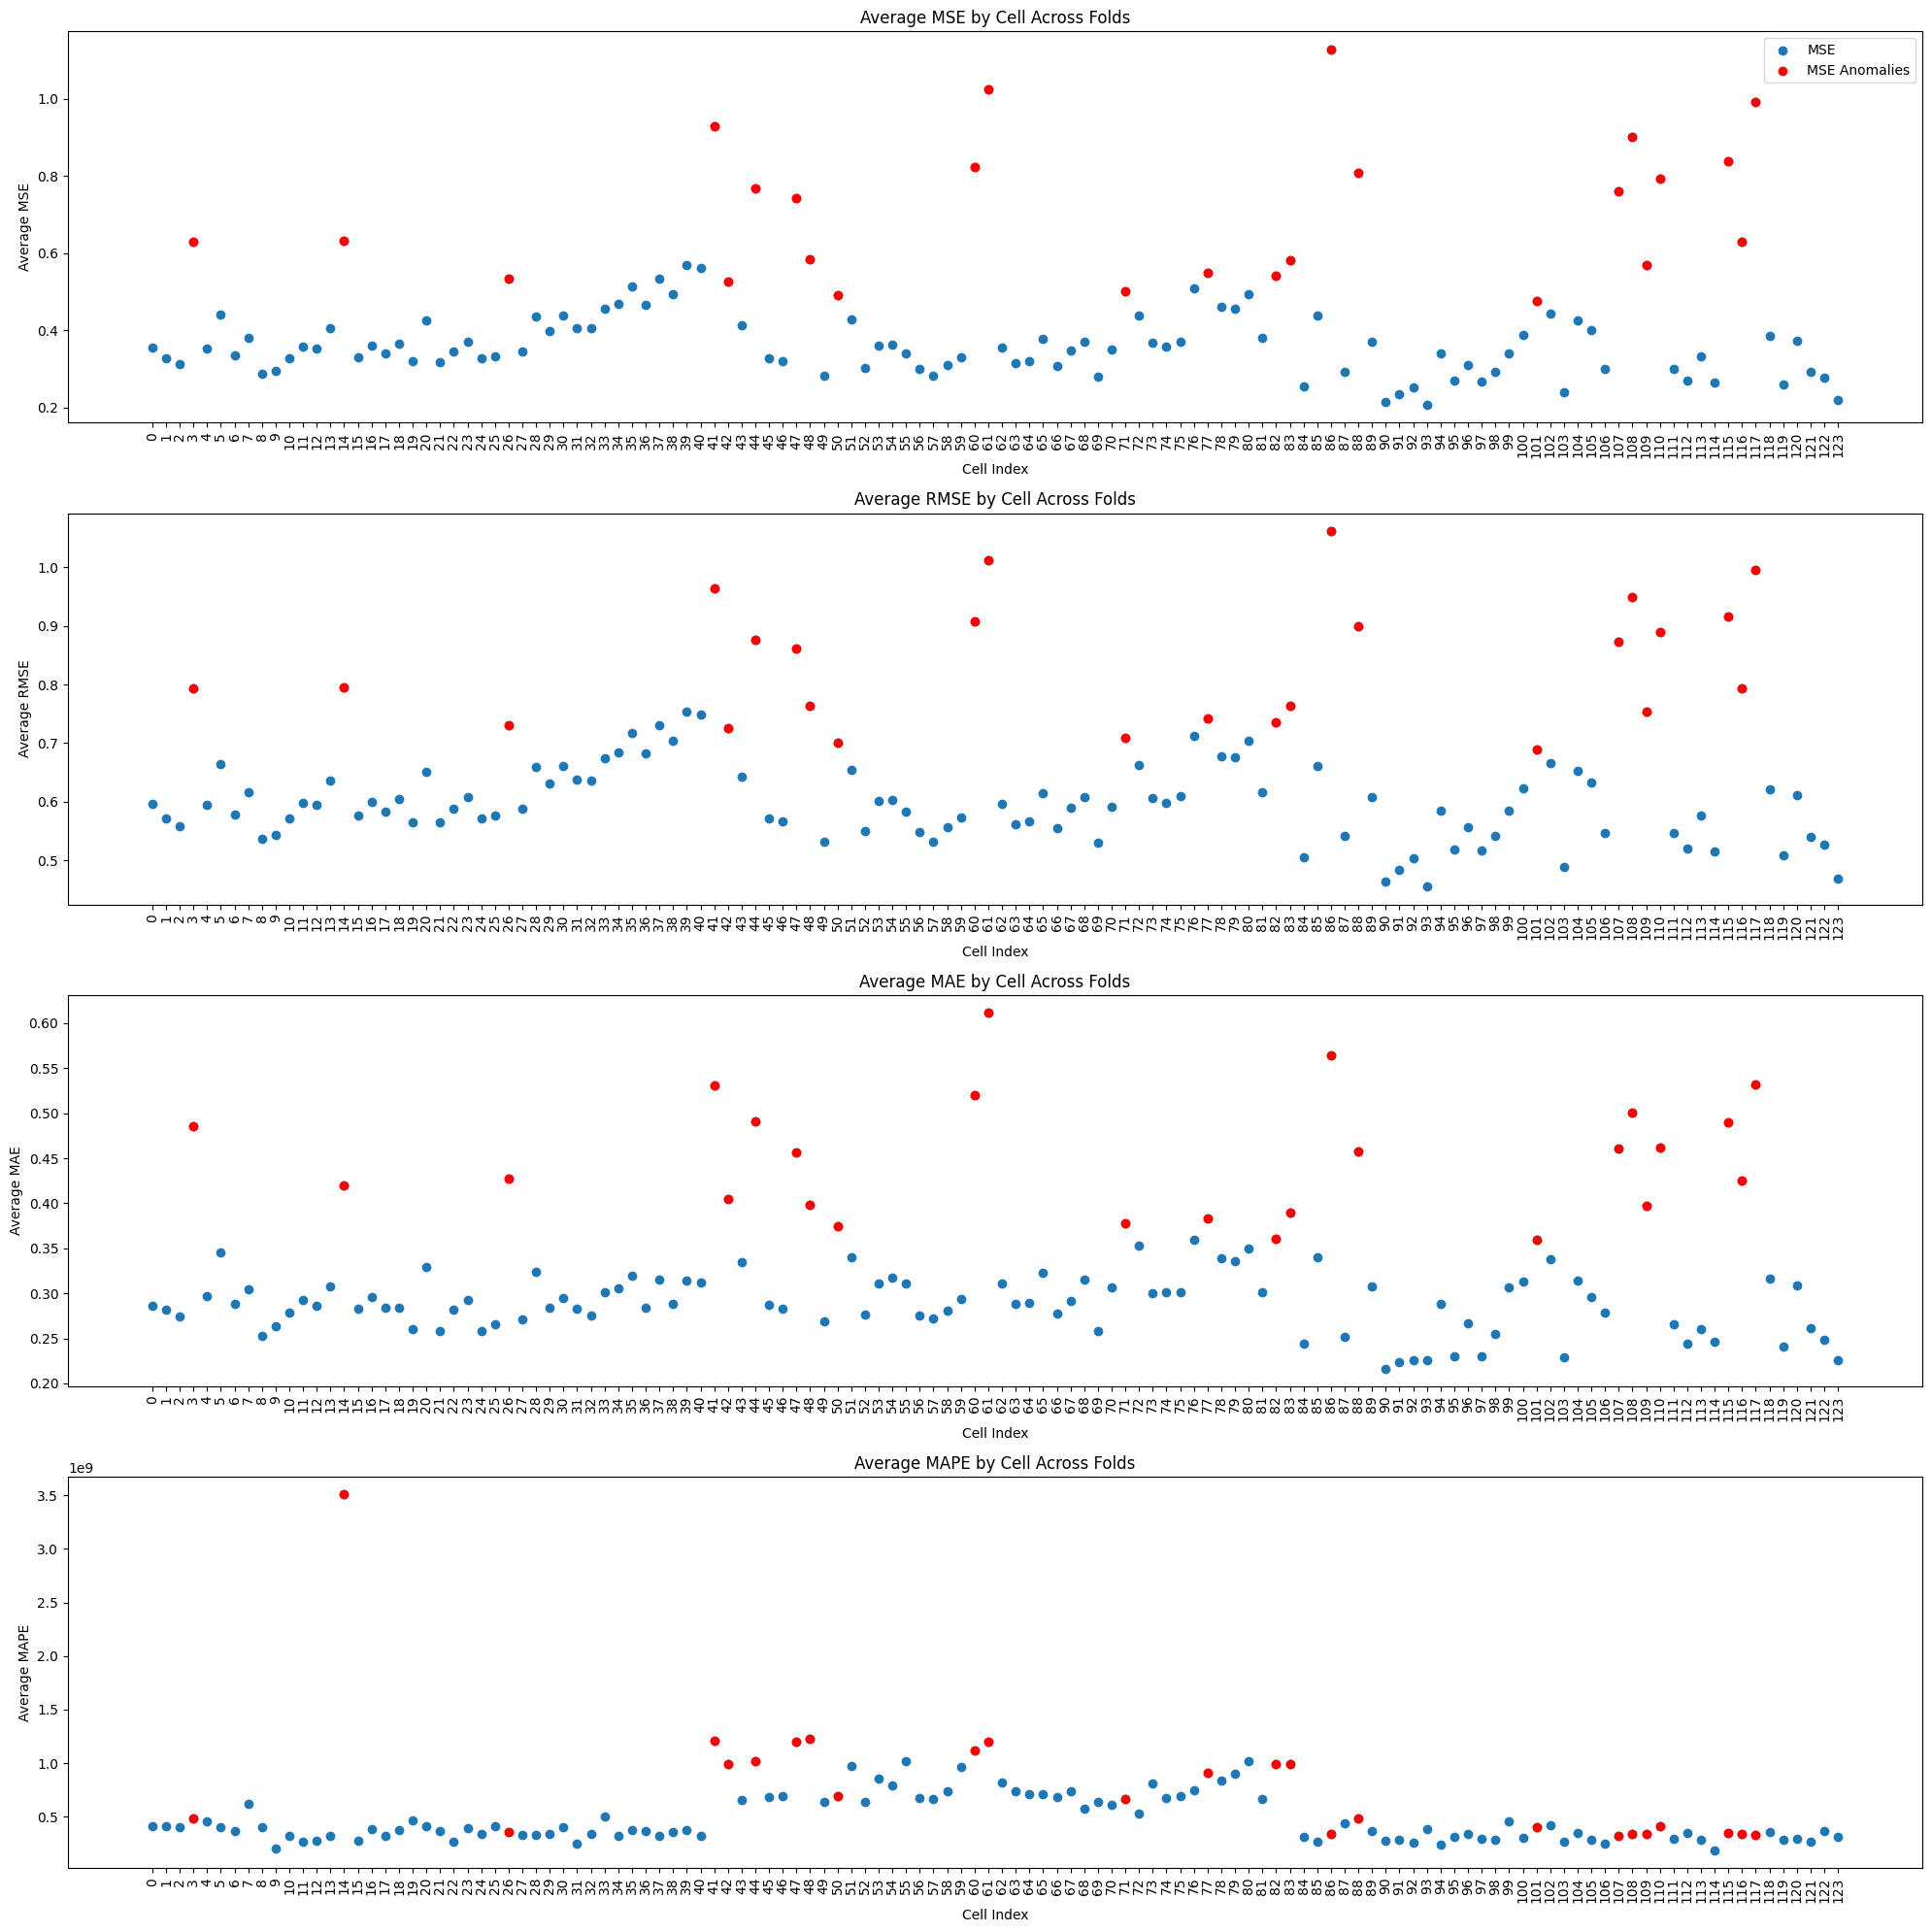

In [20]:

anomaly_detector_seq2seq_ae_v2= AnomalyDetector()
anomalies_seq2seq_ae_v2, metric_errors_seq2seq_ae_v2 = anomaly_detector_seq2seq_ae_v2.detect_anomalies(seq2seq_ae_v2_average_error_metrics_by_cells, 
                                                                                             metric='mae', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_seq2seq_ae_v2)
anomaly_detector_seq2seq_ae_v2.visual(seq2seq_ae_v2_average_error_metrics_by_cells, anomalies_seq2seq_ae_v2)


[14 41 42 44 47 48 51 53 54 55 58 59 60 61 62 63 67 73 76 77 78 79 80 82
 83]


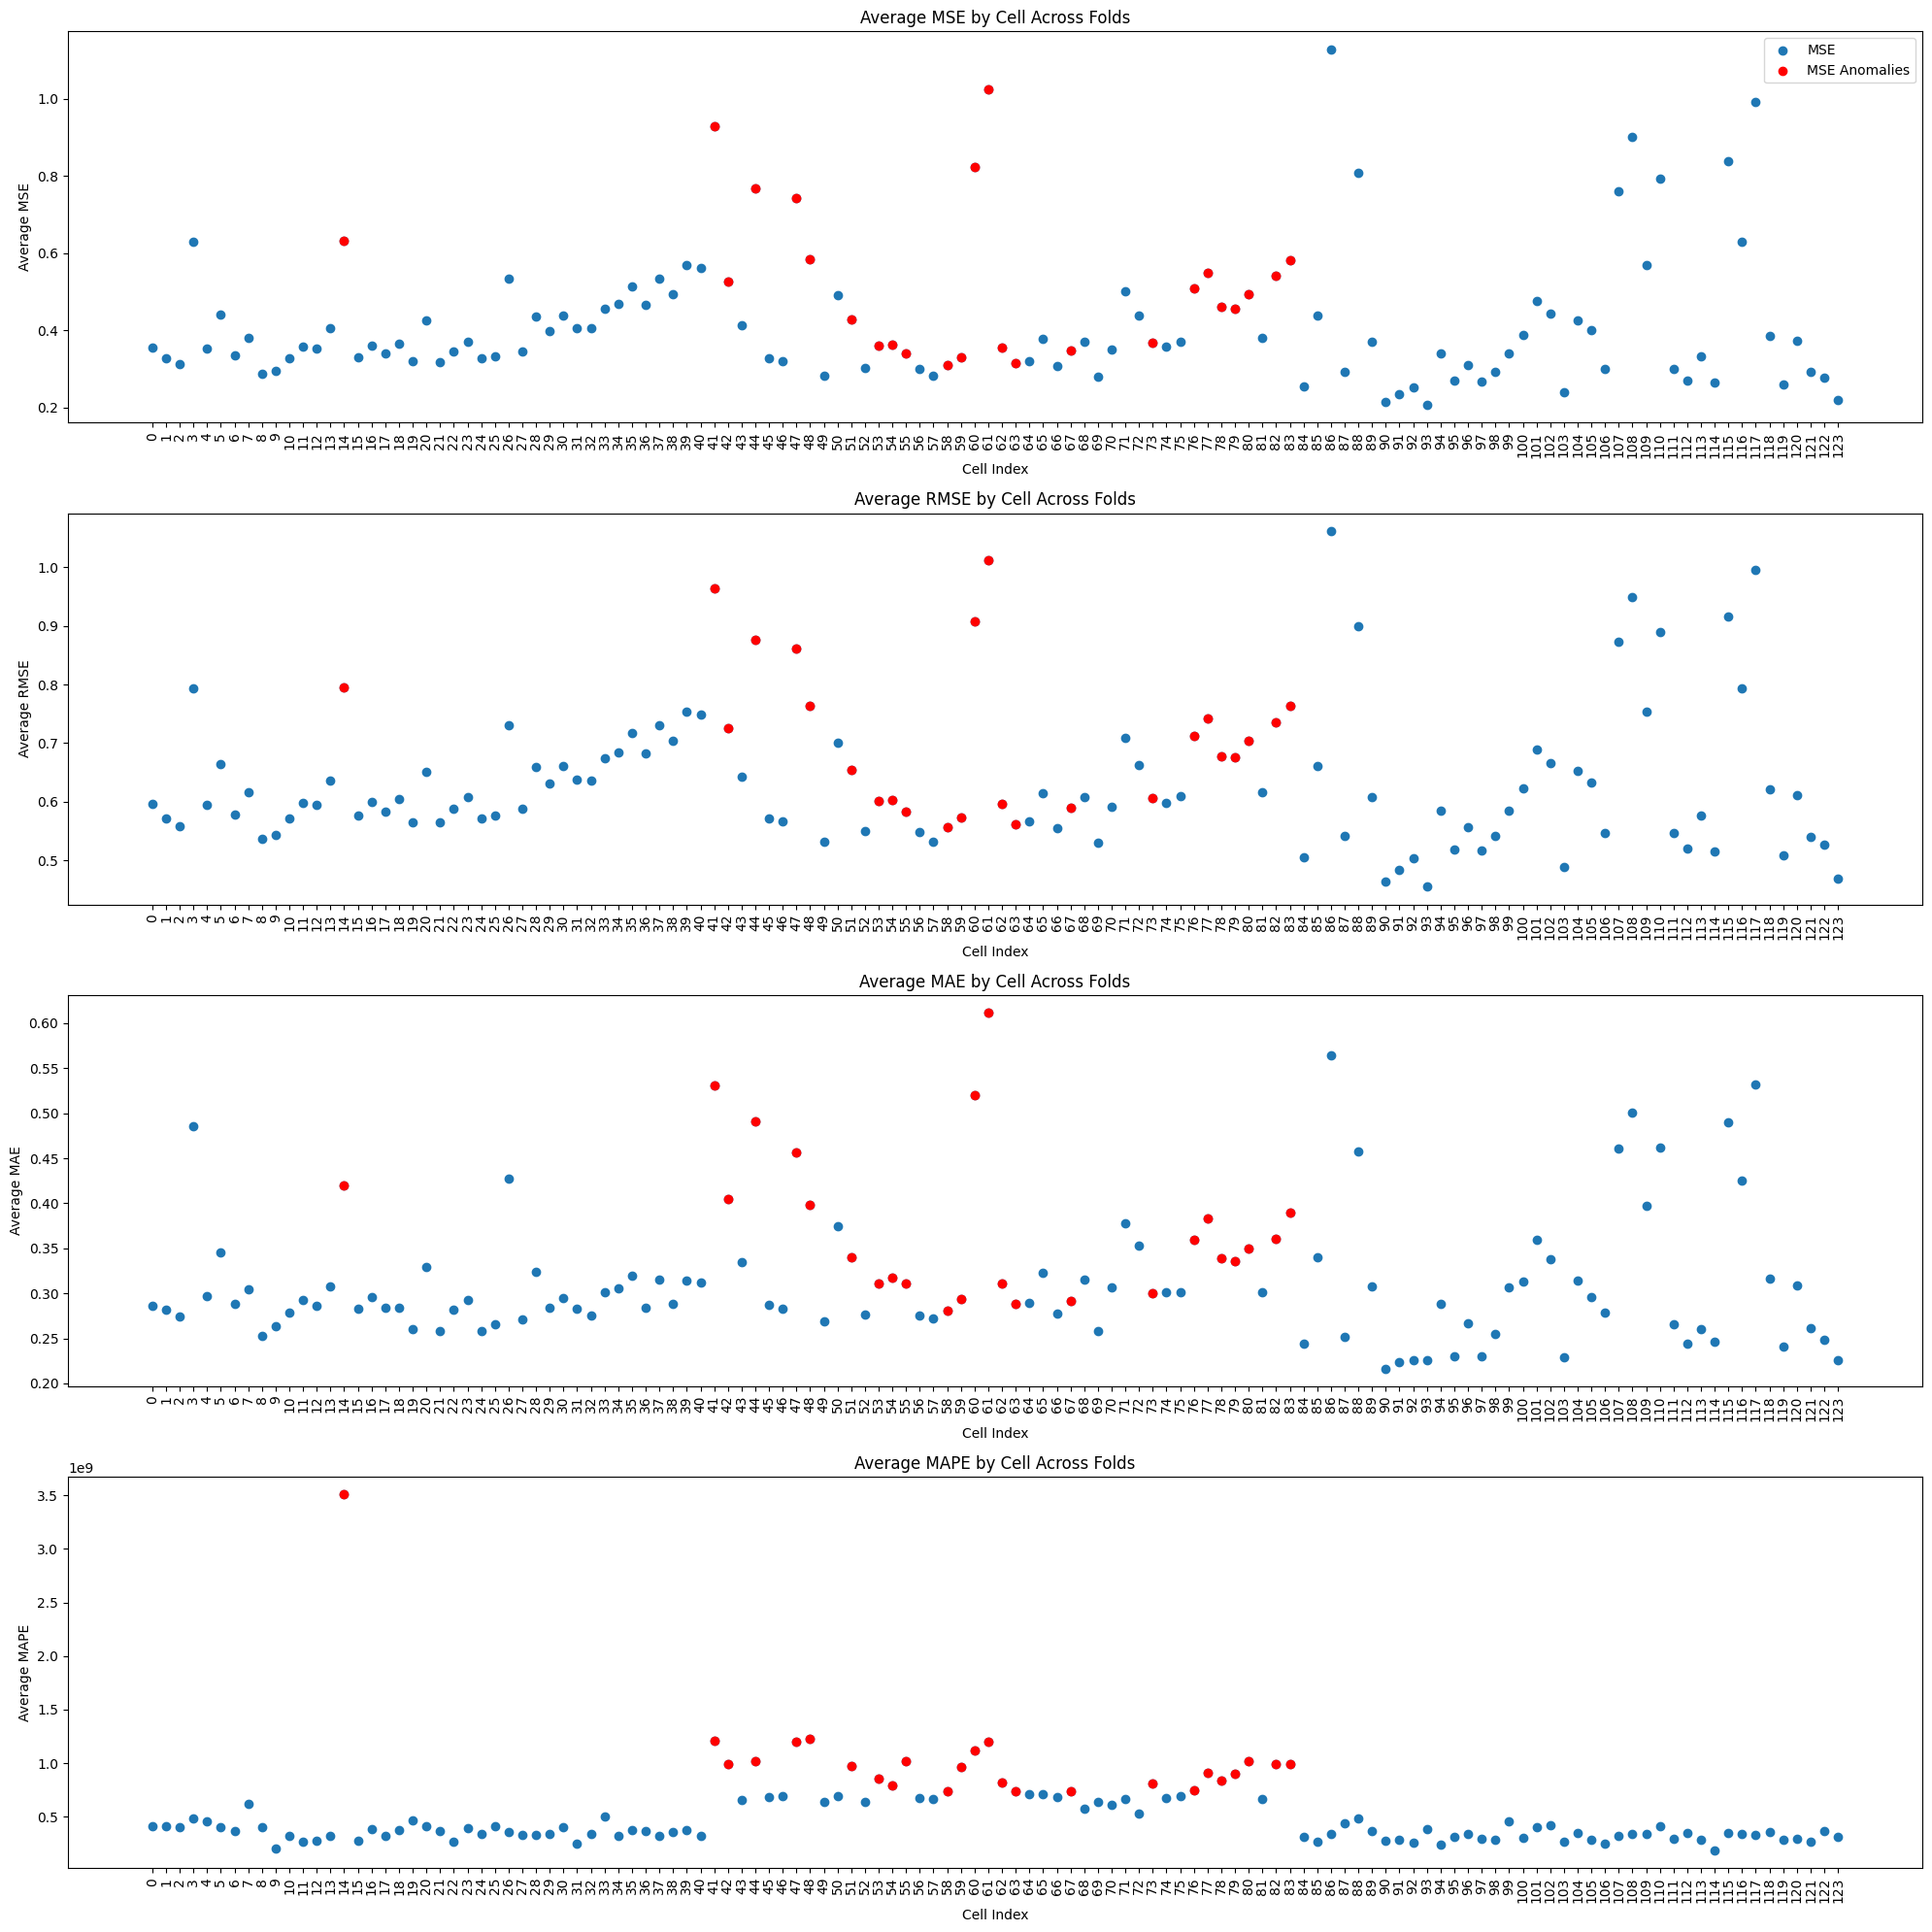

In [21]:
anomalies_seq2seq_ae_v2, metric_errors_seq2seq_ae_v2 = anomaly_detector_seq2seq_ae_v2.detect_anomalies(seq2seq_ae_v2_average_error_metrics_by_cells, 
                                                                                             metric='mape', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_seq2seq_ae_v2)
anomaly_detector_seq2seq_ae_v2.visual(seq2seq_ae_v2_average_error_metrics_by_cells, anomalies_seq2seq_ae_v2)

In [19]:
seq2seq_ae_v3_model, cae_v3_encoder = create_seq2seq_ae_v3(1000, 8)

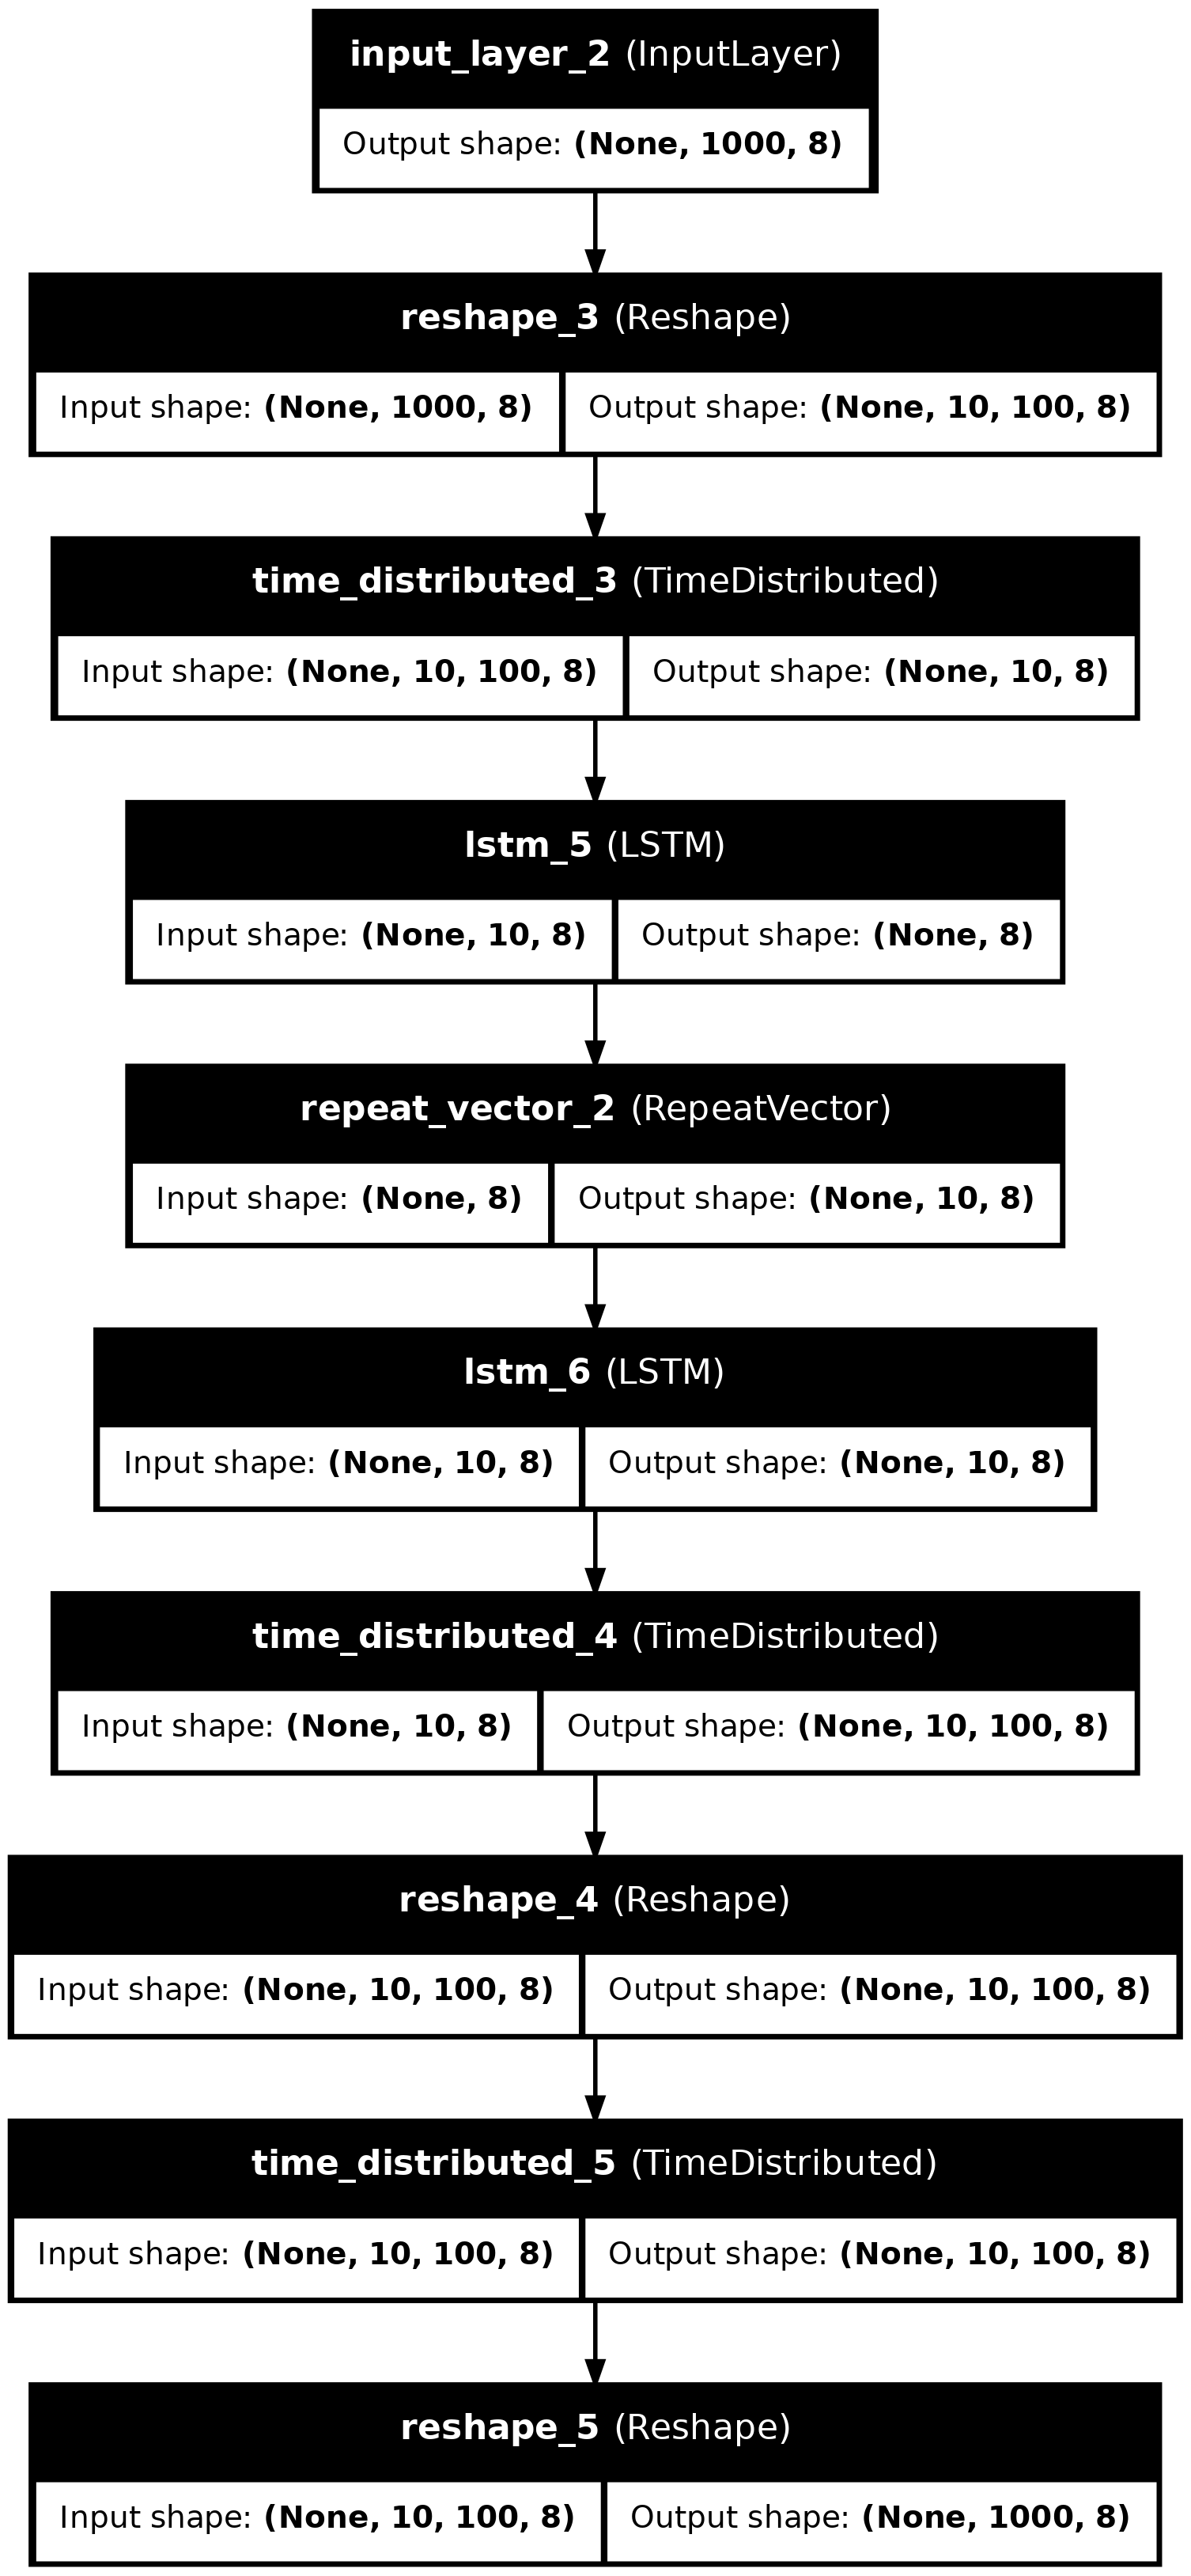

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(seq2seq_ae_v3_model, to_file='seq2seq_ae_v3_model.png', show_shapes=True, show_layer_names=True)

In [34]:
seq2seq_ae_v3_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 10, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 8)          │           544 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 100, 8)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 10, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 100, 8)     │           544 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 1000, 8)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,176 (8.50 KB)

 Trainable params: 2,176 (8.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
seq2seq_ae_v3 = AutoencoderTrainer(base_dir, 'create_seq2seq_ae_v3_t2', batdata, seq2seq_ae_v3_model)

In [24]:
seq2seq_ae_v3.train(learning_rate = 0.001, batch_size=128, max_epoch=300, no_patience=20)

100%|██████████| 300/300 [1:12:32<00:00, 14.51s/epoch, loss=0.19, mae=0.252, mape=169, rmse=0.436] 


In [33]:
seq2seq_ae_v3_average_error_metrics_by_cells = seq2seq_ae_v3.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step
Prediction time: 24.2904794216156 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step
[  3  14  26  41  42  44  47  48  50  60  61  71  76  77  83  86  88  89
 107 108 109 110 115 116 117]


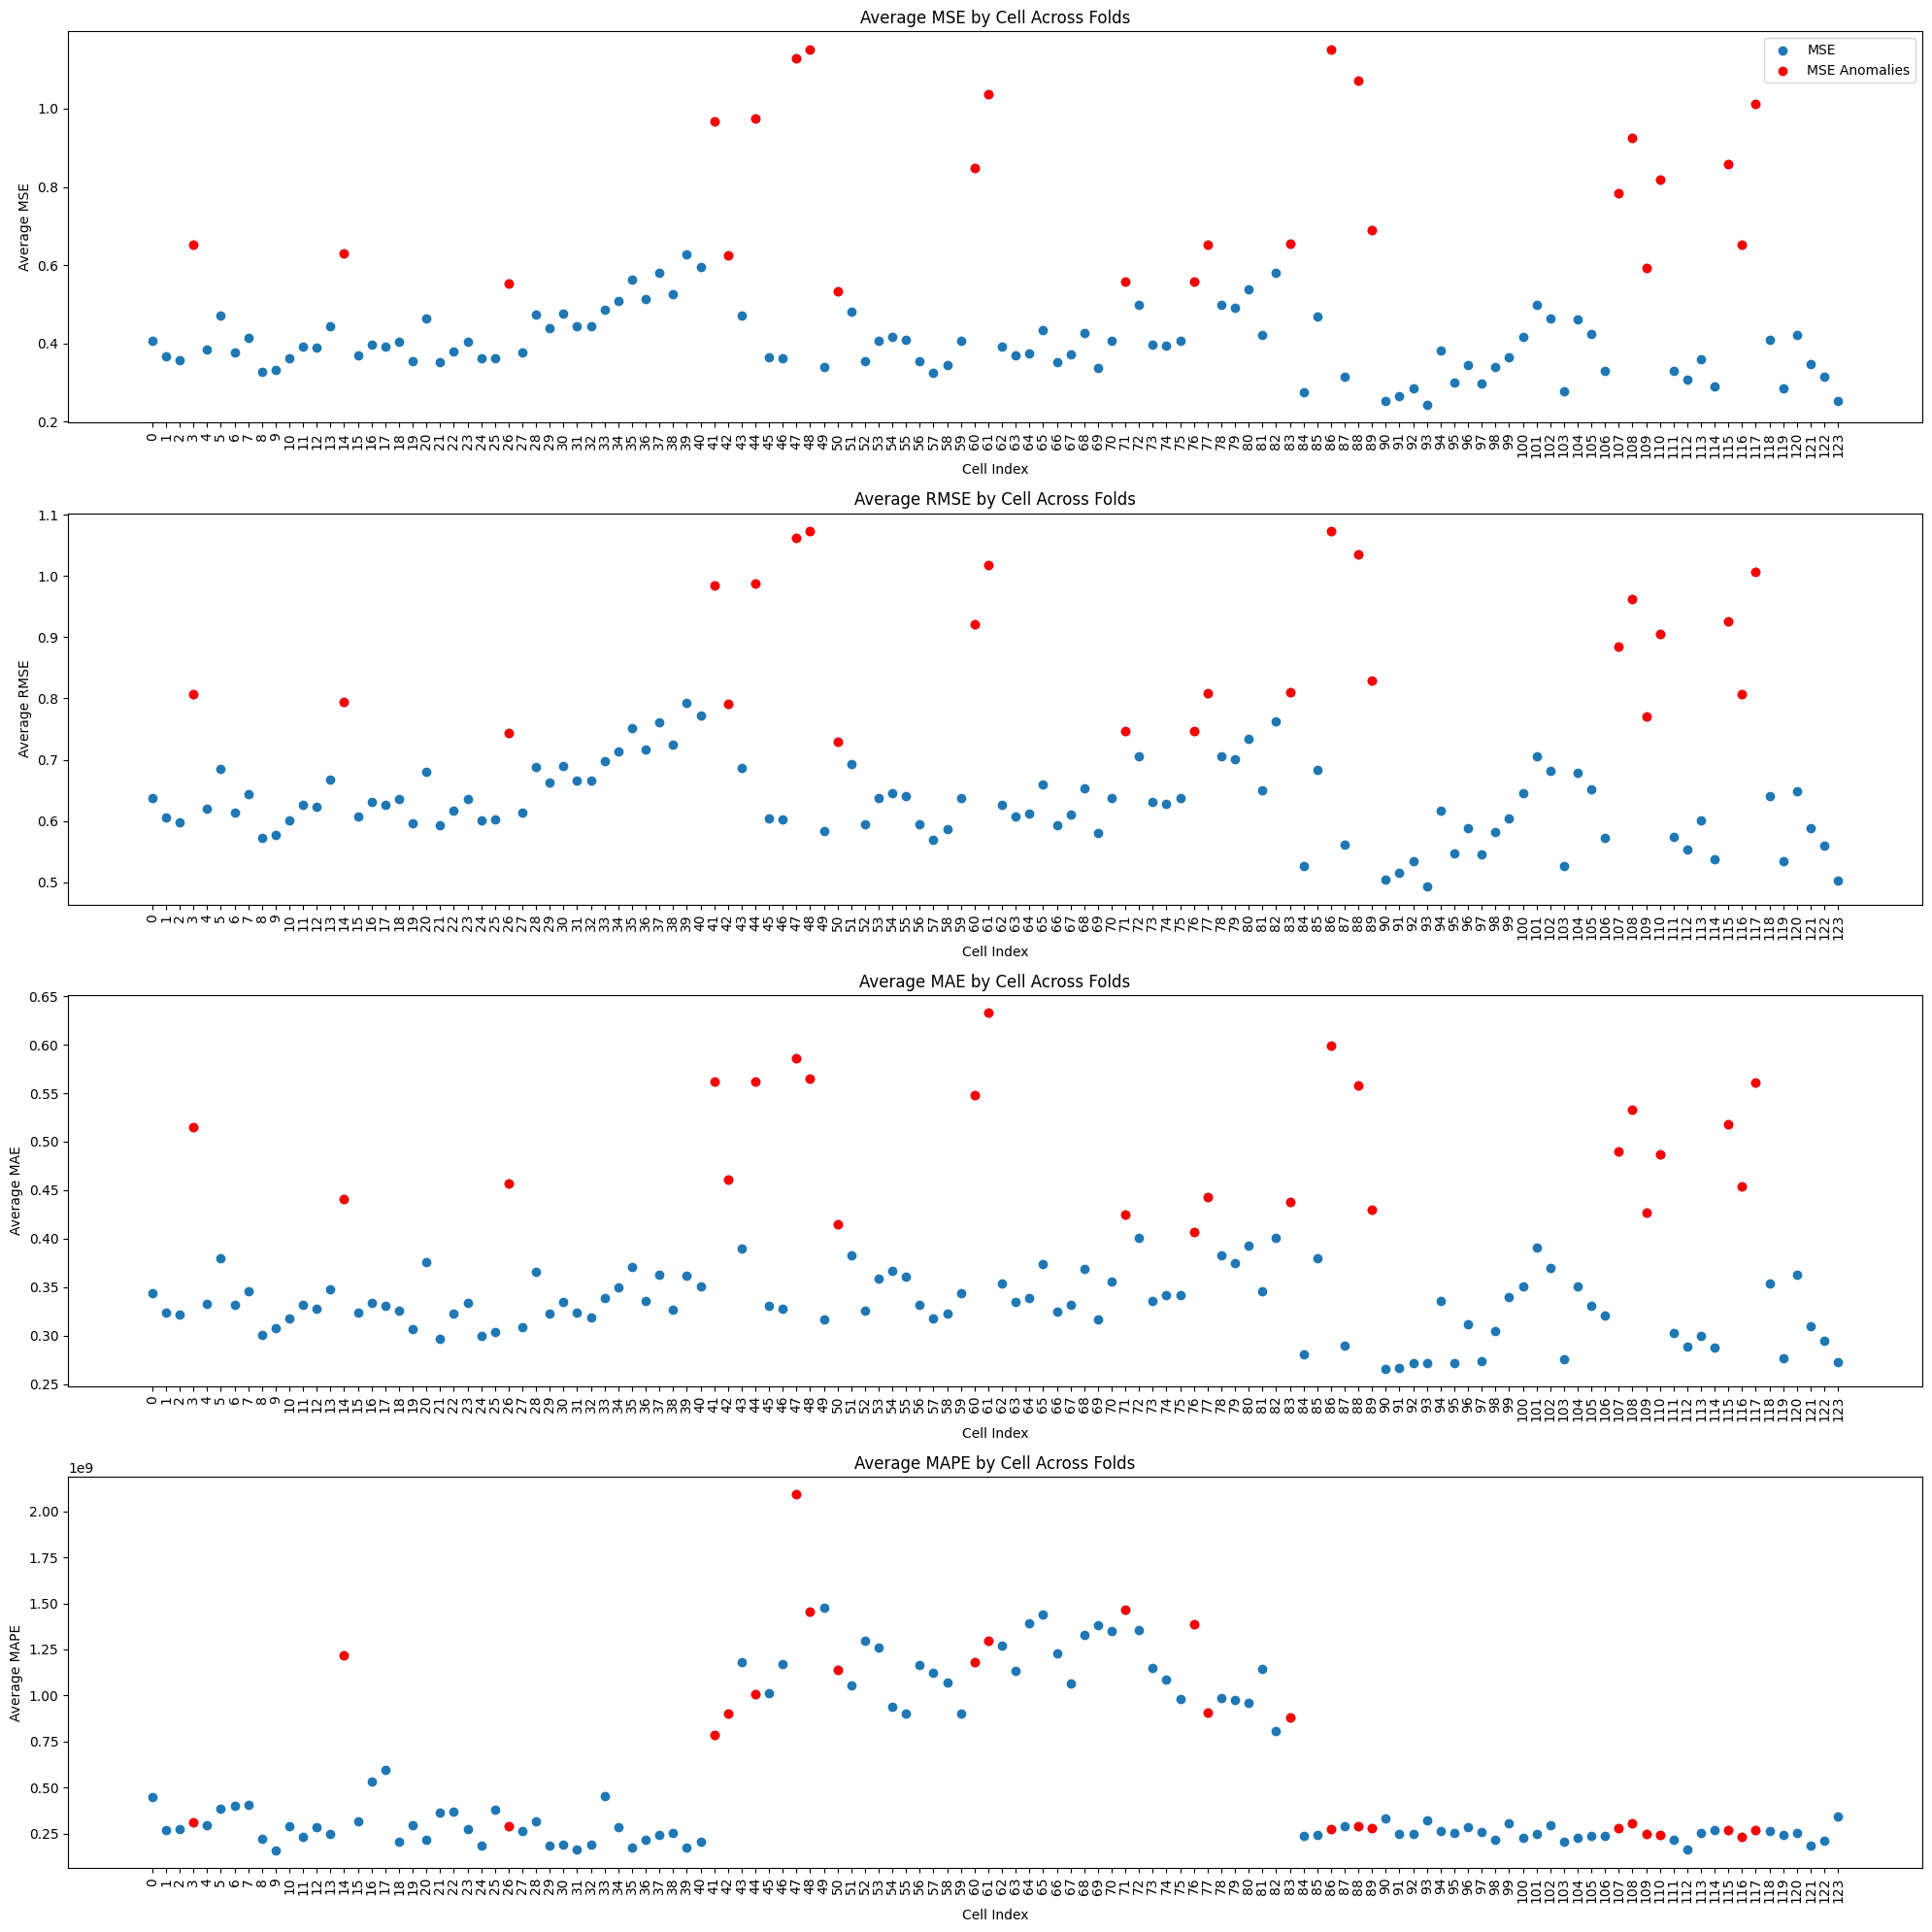

In [25]:

anomaly_detector_seq2seq_ae_v3= AnomalyDetector()
anomalies_seq2seq_ae_v3, metric_errors_seq2seq_ae_v3 = anomaly_detector_seq2seq_ae_v3.detect_anomalies(seq2seq_ae_v3_average_error_metrics_by_cells, 
                                                                                             metric='mae', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_seq2seq_ae_v3)
anomaly_detector_seq2seq_ae_v3.visual(seq2seq_ae_v3_average_error_metrics_by_cells, anomalies_seq2seq_ae_v3)

[14 43 46 47 48 49 50 52 53 56 60 61 62 63 64 65 66 68 69 70 71 72 73 76
 81]


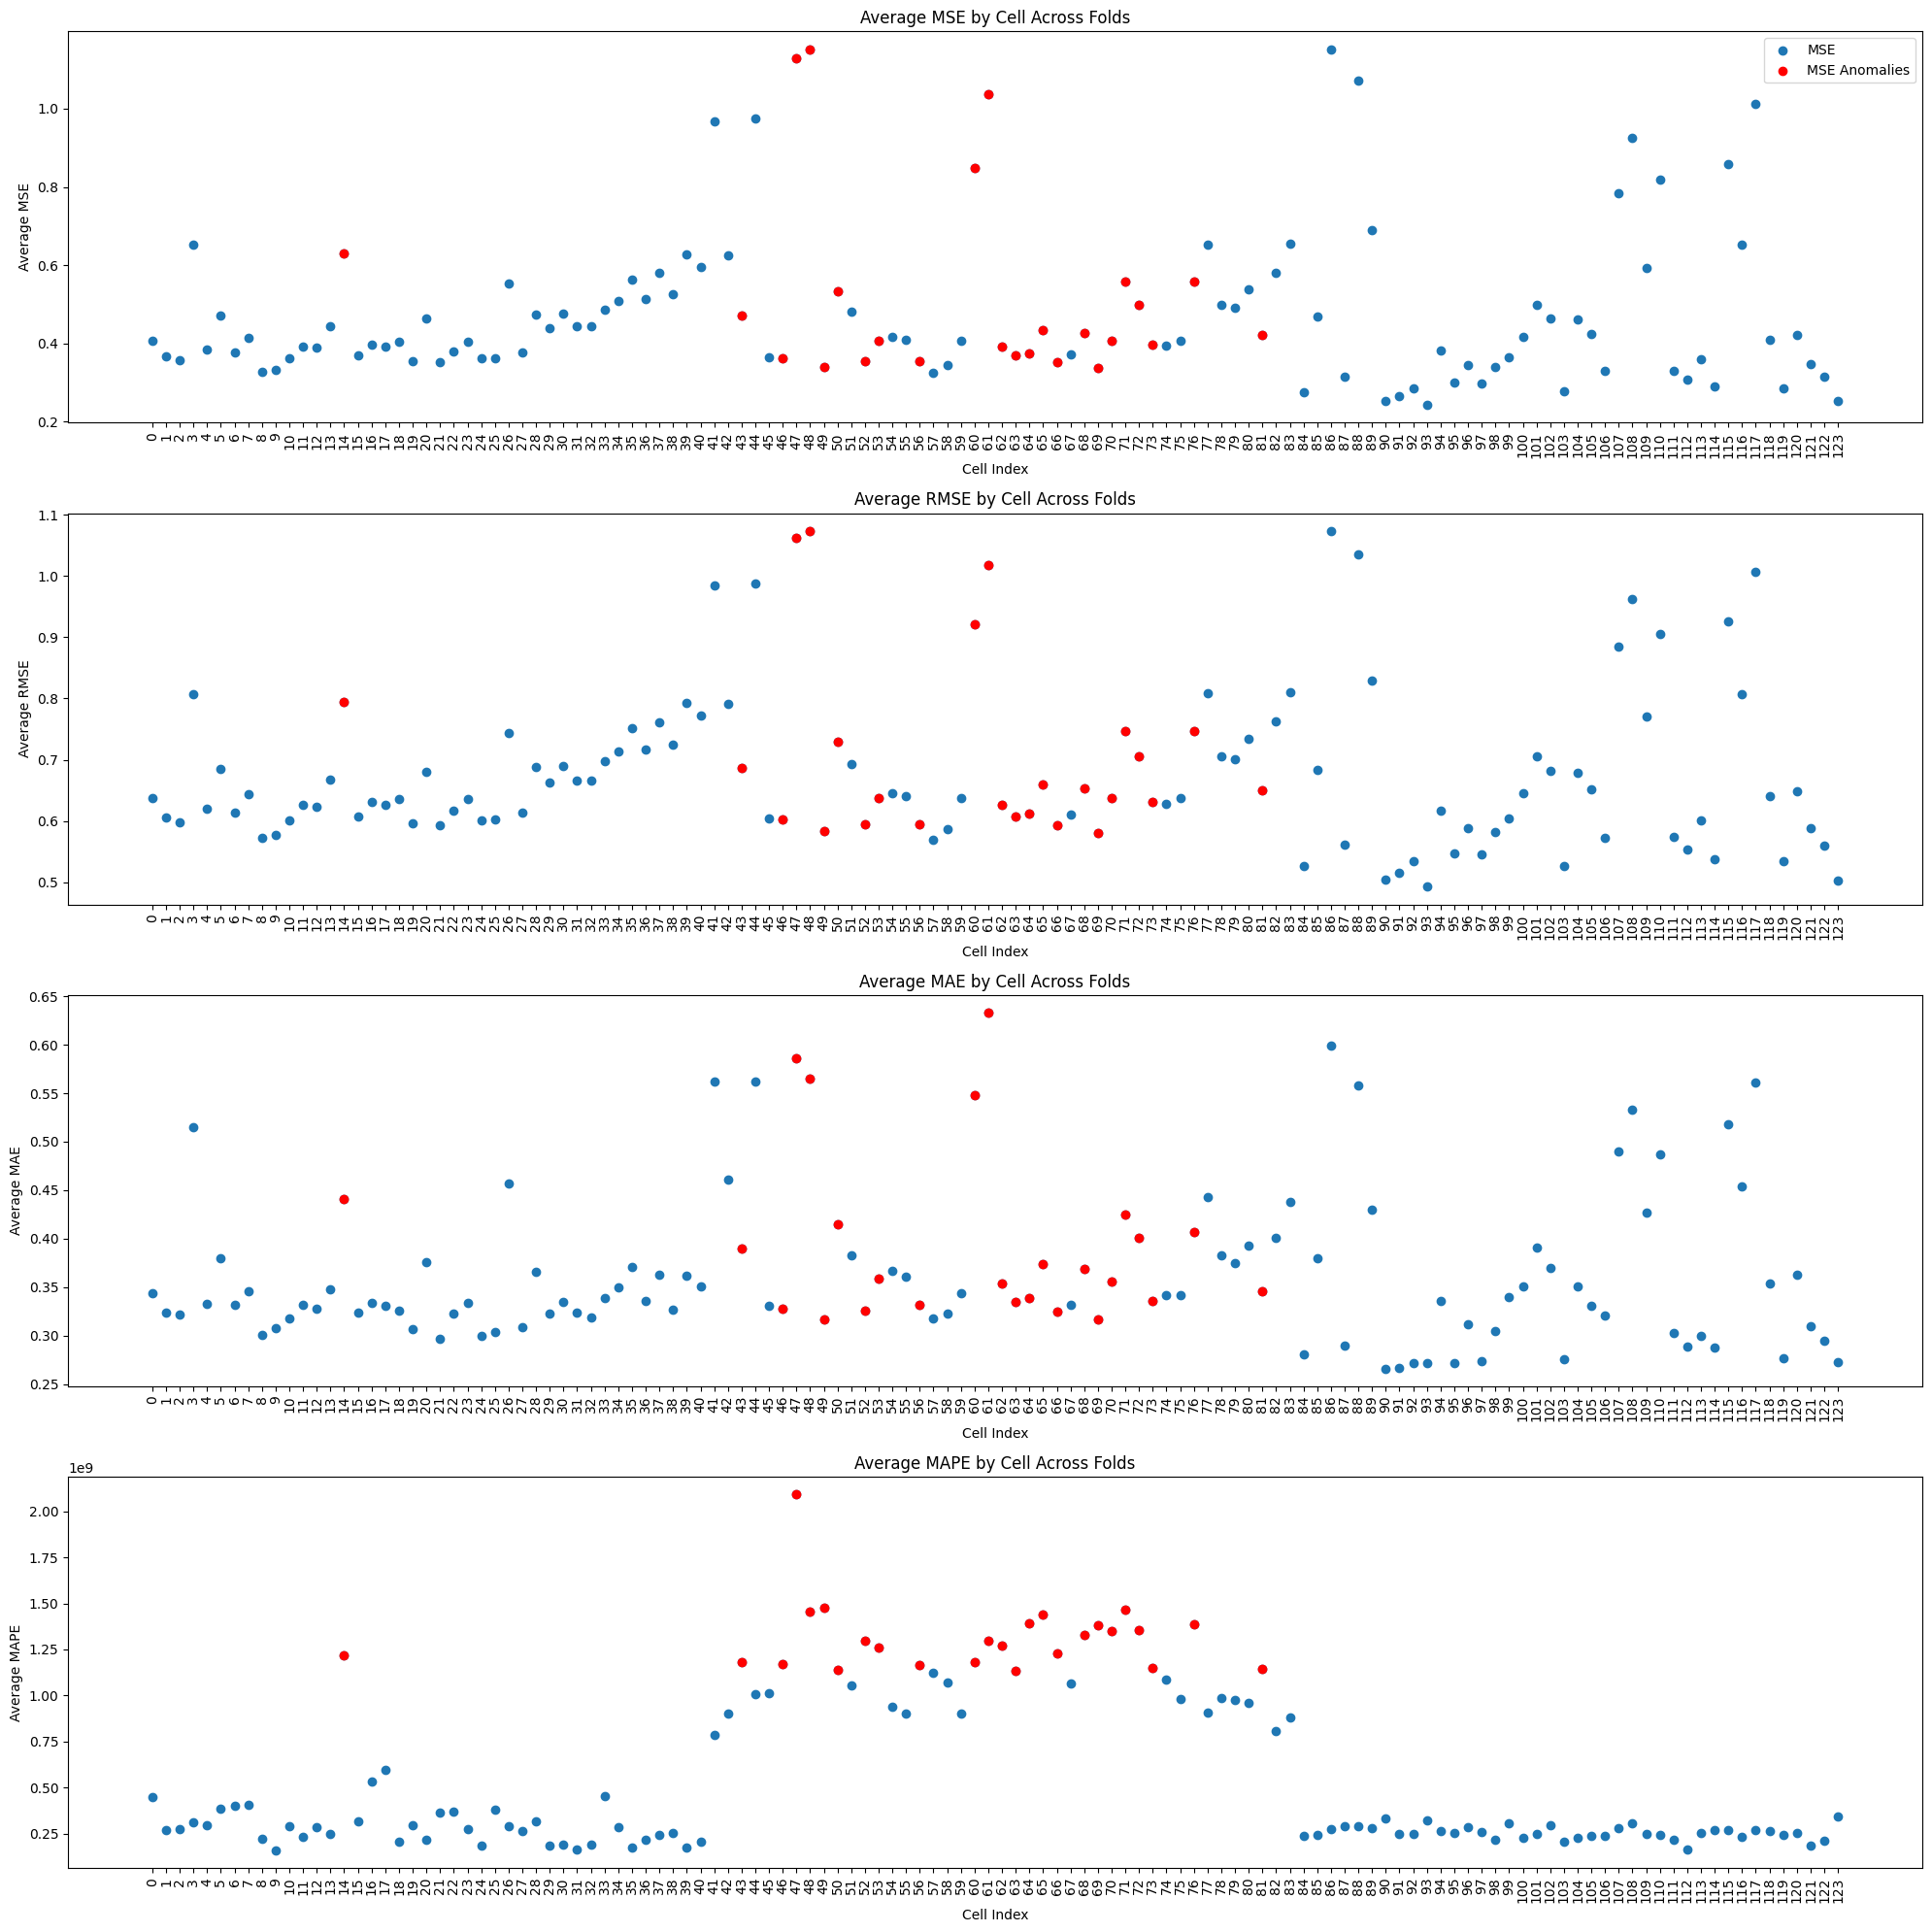

In [26]:
anomalies_seq2seq_ae_v3, metric_errors_seq2seq_ae_v3 = anomaly_detector_seq2seq_ae_v3.detect_anomalies(seq2seq_ae_v3_average_error_metrics_by_cells, 
                                                                                             metric='mape', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_seq2seq_ae_v3)
anomaly_detector_seq2seq_ae_v3.visual(seq2seq_ae_v3_average_error_metrics_by_cells, anomalies_seq2seq_ae_v3)